# Library Import

In [6]:
# Set seed for reproducibility
SEED = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import time

# Set seeds for random number generators in NumPy and Python
np.random.seed(SEED)
random.seed(SEED)

# Import PyTorch
import torch
torch.manual_seed(SEED)
from torch import nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
# from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset, DataLoader, WeightedRandomSampler
logs_dir = "tensorboard"
!pkill -f tensorboard
%load_ext tensorboard
!mkdir -p models


if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    torch.mps.manual_seed(SEED)
else:
    device = torch.device("cpu")

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {device}")

# Import other libraries
import copy
import shutil
from itertools import product
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, RobustScaler

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
PyTorch version: 2.9.0
Device: mps


# Data Loading

In [7]:
X_train = pd.read_csv('/Users/bencegaborpeter/gitclones/AN2DL_PiratePain/data/pirate_pain_train.csv')
y_train = pd.read_csv('/Users/bencegaborpeter/gitclones/AN2DL_PiratePain/data/pirate_pain_train_labels.csv')

X_test = pd.read_csv('/Users/bencegaborpeter/gitclones/AN2DL_PiratePain/data/pirate_pain_test.csv')

# Exploration and Data Analysis

In [8]:
# Display the first 10 rows of X_train
X_train.head(10)

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,n_legs,n_hands,n_eyes,joint_00,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
0,0,0,2,0,2,1,two,two,two,1.094705,...,3.499558e-06,1.945042e-06,3.999558e-06,1.153299e-05,0.000004,0.017592,0.013508,0.026798,0.027815,0.5
1,0,1,2,2,2,2,two,two,two,1.135183,...,3.976952e-07,6.765107e-07,6.019627e-06,4.643774e-08,0.000000,0.013352,0.000000,0.013377,0.013716,0.5
2,0,2,2,0,2,2,two,two,two,1.080745,...,1.533820e-07,1.698525e-07,1.446051e-06,2.424536e-06,0.000003,0.016225,0.008110,0.024097,0.023105,0.5
3,0,3,2,2,2,2,two,two,two,0.938017,...,1.006865e-05,5.511079e-07,1.847597e-06,5.432416e-08,0.000000,0.011832,0.007450,0.028613,0.024648,0.5
4,0,4,2,2,2,2,two,two,two,1.090185,...,4.437266e-06,1.735459e-07,1.552722e-06,5.825366e-08,0.000007,0.005360,0.002532,0.033026,0.025328,0.5
5,0,5,2,0,2,1,two,two,two,1.146031,...,1.073167e-06,1.753837e-07,2.957340e-07,6.217311e-08,0.000007,0.006150,0.006444,0.033101,0.023767,0.5
6,0,6,2,1,2,1,two,two,two,1.025870,...,1.074800e-06,1.772156e-07,1.976558e-06,1.576086e-06,0.000005,0.006495,0.006421,0.031804,0.019056,0.5
7,0,7,2,2,2,2,two,two,two,1.038597,...,8.829074e-07,1.790415e-07,2.210562e-06,1.485741e-06,0.000000,0.015998,0.005397,0.035552,0.015732,0.5
8,0,8,2,2,0,1,two,two,two,0.984251,...,1.621055e-06,1.165161e-06,3.030164e-07,5.416678e-07,0.000000,0.020539,0.008517,0.008635,0.015257,0.5
9,0,9,0,2,2,2,two,two,two,1.054999,...,1.609114e-06,3.959558e-06,2.017157e-06,1.154349e-06,0.000007,0.007682,0.021383,0.034006,0.028966,0.5


In [9]:
# Display the first 10 rows of y_train
y_train.head(10)

,sample_index,label
0,0,no_pain
1,1,no_pain
2,2,low_pain
3,3,no_pain
4,4,no_pain
5,5,no_pain
6,6,no_pain
7,7,no_pain
8,8,no_pain
9,9,no_pain


In [10]:
#  Display a summary of the X_train dataframe
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105760 entries, 0 to 105759
Data columns (total 40 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   sample_index   105760 non-null  int64  
 1   time           105760 non-null  int64  
 2   pain_survey_1  105760 non-null  int64  
 3   pain_survey_2  105760 non-null  int64  
 4   pain_survey_3  105760 non-null  int64  
 5   pain_survey_4  105760 non-null  int64  
 6   n_legs         105760 non-null  object 
 7   n_hands        105760 non-null  object 
 8   n_eyes         105760 non-null  object 
 9   joint_00       105760 non-null  float64
 10  joint_01       105760 non-null  float64
 11  joint_02       105760 non-null  float64
 12  joint_03       105760 non-null  float64
 13  joint_04       105760 non-null  float64
 14  joint_05       105760 non-null  float64
 15  joint_06       105760 non-null  float64
 16  joint_07       105760 non-null  float64
 17  joint_08       105760 non-nul

In [11]:
# Display a sumary of the y_train dataframe
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 661 entries, 0 to 660
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   sample_index  661 non-null    int64 
 1   label         661 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.5+ KB


In [12]:
# Generate descriptive statistics for numerical columns in the X_train dataframe
X_train.describe()

,sample_index,time,pain_survey_1,pain_survey_2,pain_survey_3,pain_survey_4,joint_00,joint_01,joint_02,joint_03,...,joint_21,joint_22,joint_23,joint_24,joint_25,joint_26,joint_27,joint_28,joint_29,joint_30
count,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,105760.000000,...,1.057600e+05,1.057600e+05,1.057600e+05,1.057600e+05,1.057600e+05,105760.000000,105760.000000,105760.000000,105760.000000,105760.0
mean,330.000000,79.500000,1.633746,1.654851,1.653640,1.663134,0.943095,0.916955,0.779296,0.767921,...,3.972126e-05,4.176794e-05,3.561780e-05,3.138109e-05,1.024604e-04,0.041905,0.058244,0.049886,0.062273,0.5
std,190.814948,46.187338,0.682423,0.669639,0.666649,0.661994,0.202051,0.197608,0.295605,0.300787,...,4.974496e-03,5.472244e-03,1.235450e-03,4.062914e-04,3.206128e-03,0.060293,0.079819,0.060773,0.072597,0.0
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001015,0.005403,...,0.000000e+00,1.510494e-07,0.000000e+00,1.063144e-08,0.000000e+00,0.000203,0.000000,0.000000,0.000000,0.5
25%,165.000000,39.750000,2.000000,2.000000,2.000000,2.000000,0.828277,0.811445,0.568850,0.520020,...,6.545878e-08,3.321650e-07,3.275038e-07,2.841805e-07,7.161332e-07,0.009885,0.012652,0.016290,0.019638,0.5
50%,330.000000,79.500000,2.000000,2.000000,2.000000,2.000000,1.005126,0.979468,0.909549,0.914834,...,8.302747e-07,1.095971e-06,1.024209e-06,8.746147e-07,3.126723e-06,0.021898,0.031739,0.031843,0.039041,0.5
75%,495.000000,119.250000,2.000000,2.000000,2.000000,2.000000,1.081039,1.056611,0.995187,0.994324,...,2.800090e-06,3.079465e-06,3.021830e-06,2.507548e-06,9.946107e-06,0.048579,0.071051,0.058741,0.079518,0.5
max,660.000000,159.000000,2.000000,2.000000,2.000000,2.000000,1.407968,1.334613,1.306046,1.254729,...,1.442198e+00,1.305001e+00,2.742411e-01,3.643074e-02,9.473540e-01,1.223617,1.187419,1.412037,1.370765,0.5


In [13]:
# Generate descriptive statistics for numerical columns in the y_train dataframe
y_train.describe()

,sample_index
count,661.000000
mean,330.000000
std,190.958547
min,0.000000
25%,165.000000
50%,330.000000
75%,495.000000
max,660.000000


# Data Preprocessing

In [14]:
# Check unique values for n_legs, n_hands, n_eyes columns
pirate_cols = ['n_legs', 'n_hands', 'n_eyes']
print("--- Before Mapping (X_train) ---")
for col in pirate_cols:
    print(f"Column '{col}': {X_train[col].unique()}")

--- Before Mapping (X_train) ---
Column 'n_legs': ['two' 'one+peg_leg']
Column 'n_hands': ['two' 'one+hook_hand']
Column 'n_eyes': ['two' 'one+eye_patch']


In [15]:
# Define the complete mapping
# This map will handle all 'pirate' and 'two' variations
pirate_map = {
    'two': 2,
    'one+peg_leg': 1,
    'one+hook_hand': 1,
    'one+eye_patch': 1
}

# List of columns to apply the map to
pirate_cols = ['n_legs', 'n_hands', 'n_eyes']

# Apply the mapping to both X_train and X_test dataframes
for col in pirate_cols:
    # Use .loc to modify the DataFrames directly
    X_train.loc[:, col] = X_train[col].map(pirate_map)
    X_test.loc[:, col] = X_test[col].map(pirate_map)

print("Successfully mapped 'pirate' columns in X_train and X_test.")

# Verify the change
print("\nAfter Mapping (X_train)")
for col in pirate_cols:
    print(f"Column '{col}': {X_train[col].unique()}")

print("\nAfter Mapping (X_test)")
for col in pirate_cols:
    print(f"Column '{col}': {X_test[col].unique()}")

Successfully mapped 'pirate' columns in X_train and X_test.

After Mapping (X_train)
Column 'n_legs': [2 1]
Column 'n_hands': [2 1]
Column 'n_eyes': [2 1]

After Mapping (X_test)
Column 'n_legs': [2 1]
Column 'n_hands': [2 1]
Column 'n_eyes': [2 1]



Data merged for plotting.


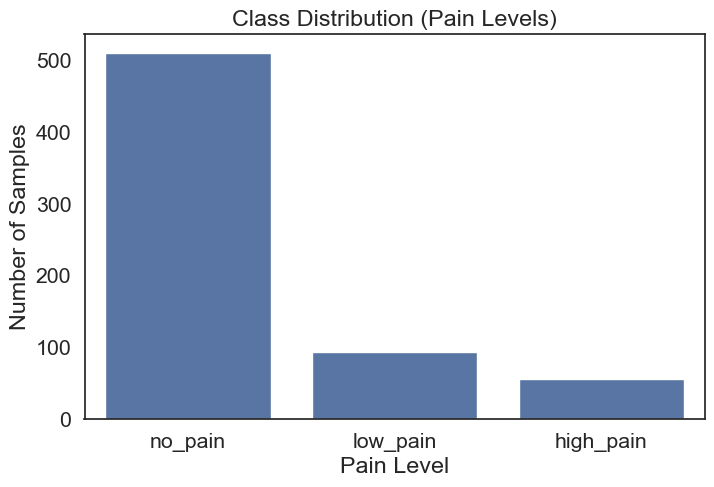

In [16]:
# Merge dataframes for plotting
label_column = 'label'
X_train_merged = X_train.merge(y_train, on='sample_index', how='left')
print(f"\nData merged for plotting.")

# Plot 1: Class Distribution ---
plt.figure(figsize=(8, 5))
sns.countplot(x=label_column, data=y_train, order=['no_pain', 'low_pain', 'high_pain'])
plt.title('Class Distribution (Pain Levels)')
plt.xlabel('Pain Level')
plt.ylabel('Number of Samples')
plt.show() # Display the plot

Data merged for plotting...


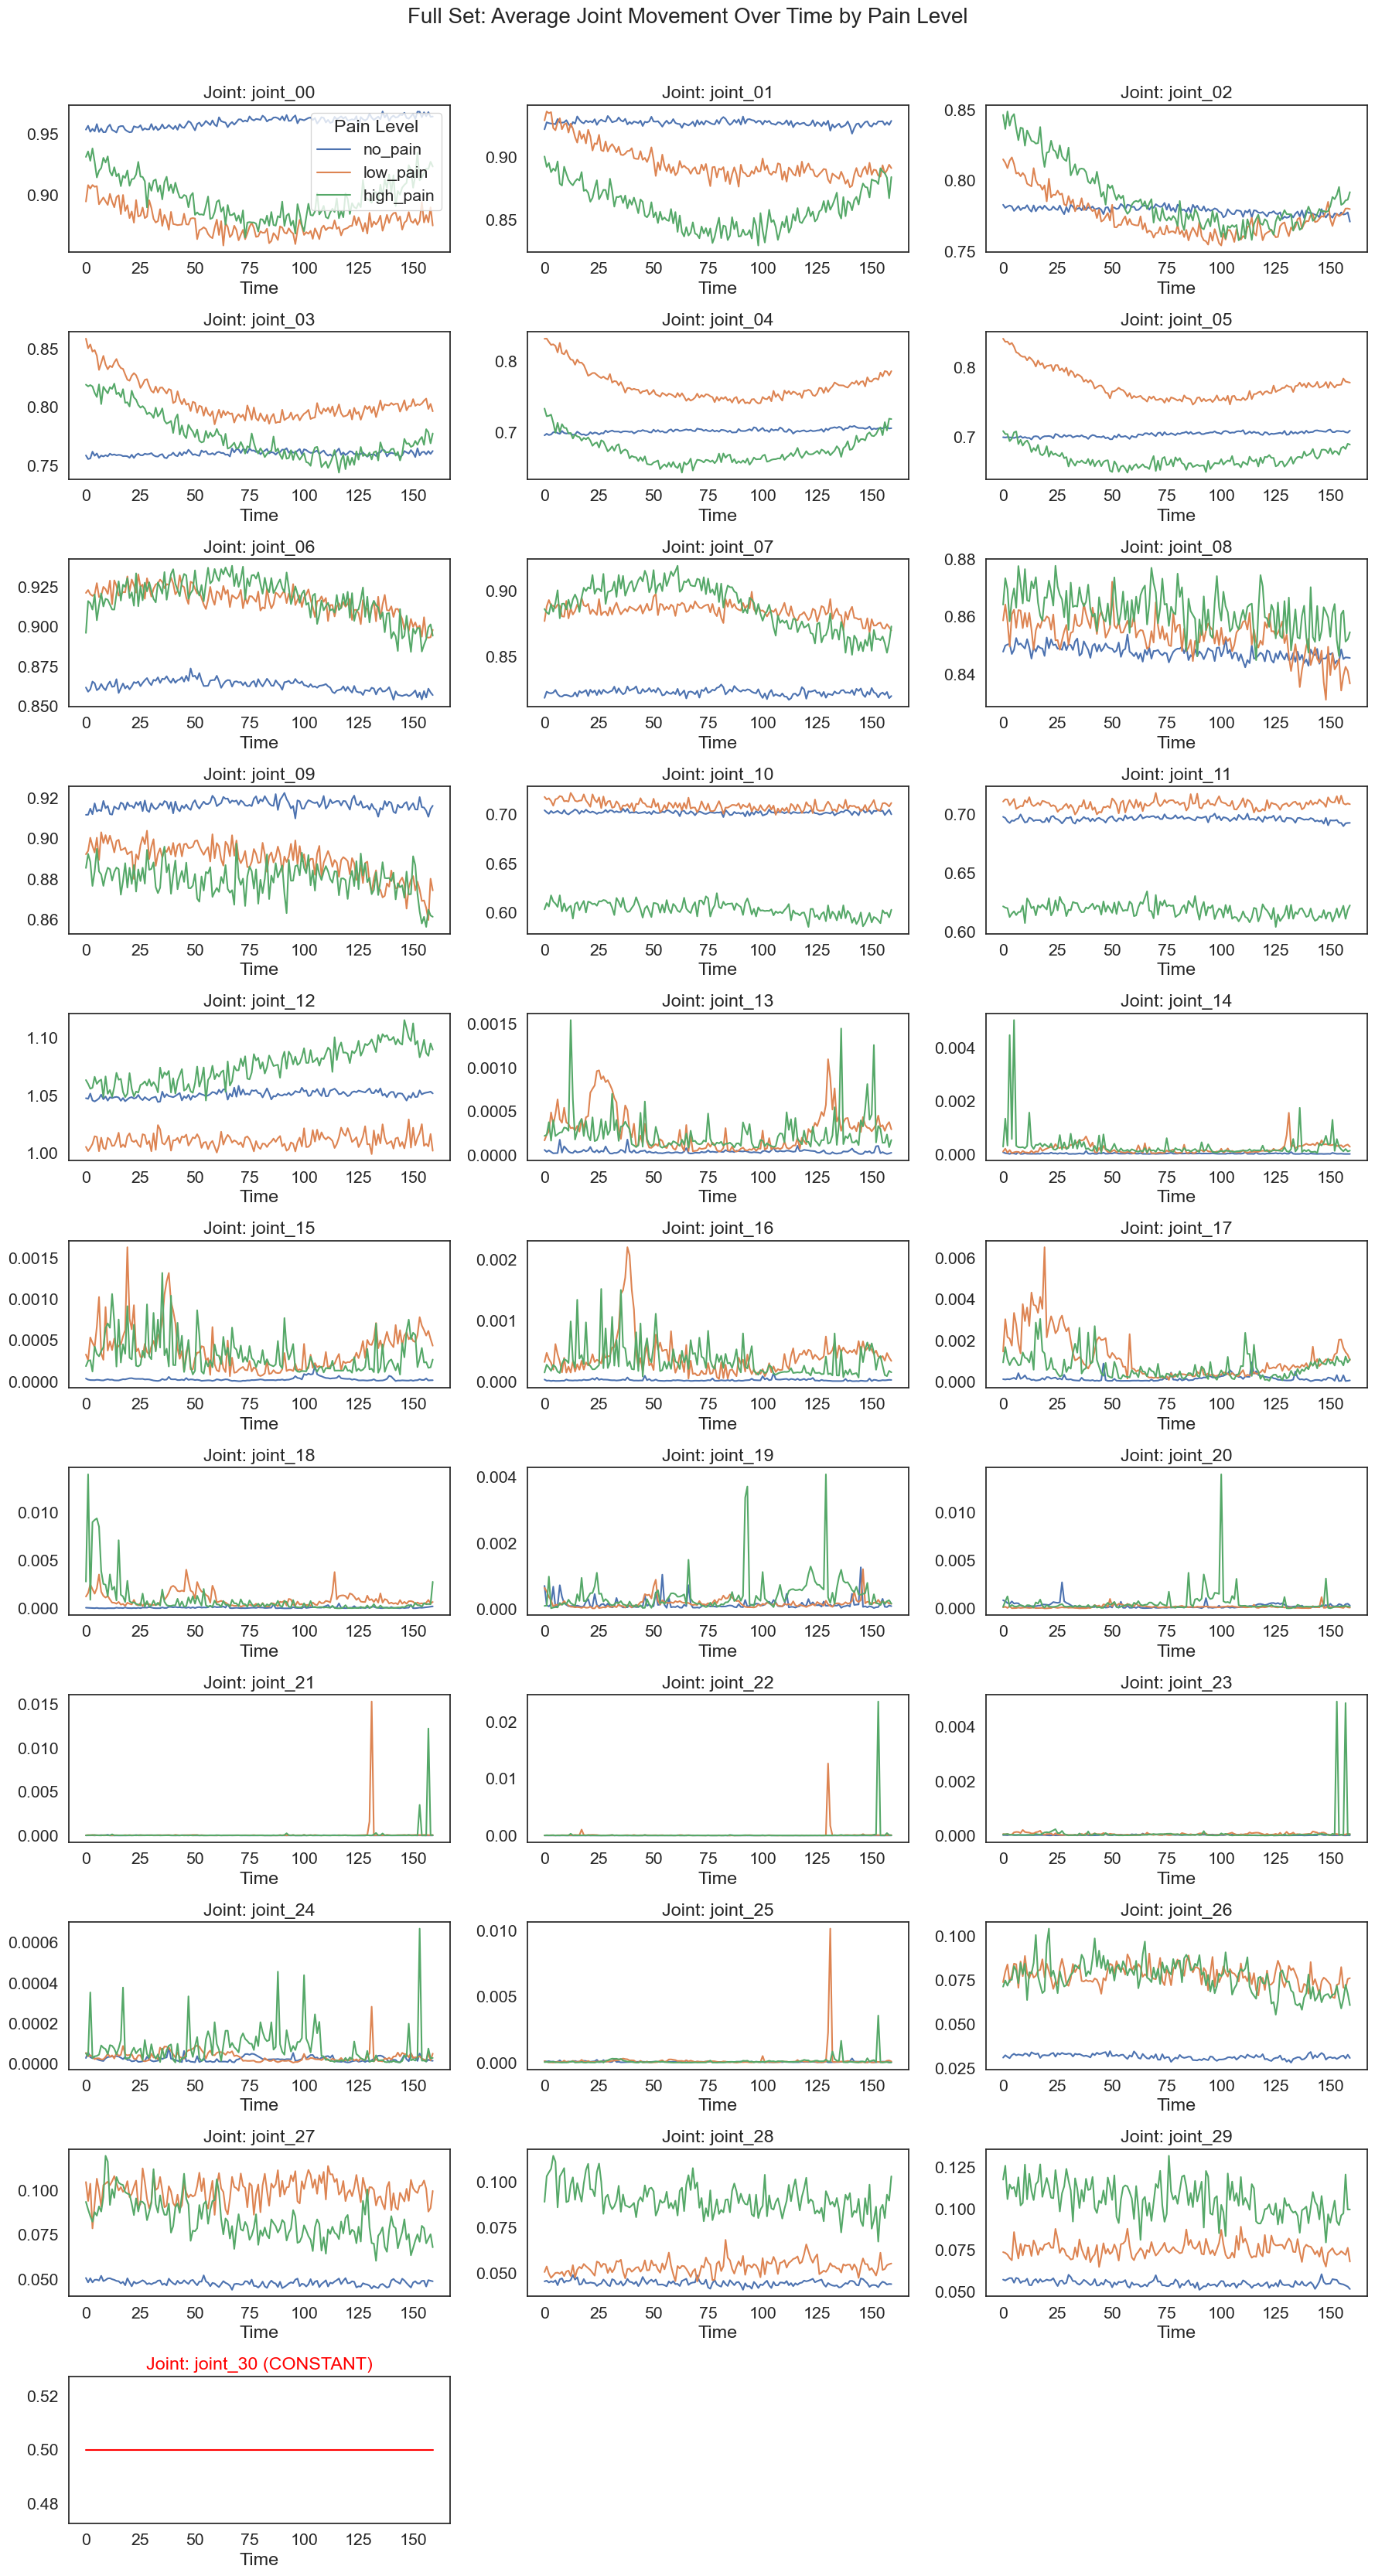

In [17]:
# Setup Data for Plotting
label_column = 'label' # The name of your label column
X_train_merged = X_train.merge(y_train, on='sample_index', how='left')
print("Data merged for plotting...")

# Define all 31 joint columns
all_31_joints = [f'joint_{i:02d}' for i in range(31)]

# Setup the figure layout
N_COLS = 3
N_ROWS = 11 # We need 11 rows to fit 31 plots (11 * 3 = 33 slots)
FIG_WIDTH = 18 # Total width of the figure
FIG_HEIGHT = 33 # Total height of the figure (3 inches per row)

fig, axes = plt.subplots(N_ROWS, N_COLS, figsize=(FIG_WIDTH, FIG_HEIGHT))
fig.suptitle('Full Set: Average Joint Movement Over Time by Pain Level', fontsize=20, y=1.01)

# Flatten the axes array (from 11x3 to 33,) for easy iteration
axes = axes.flatten()

# Iterate and Plot each joint
for i, joint in enumerate(all_31_joints):
    ax = axes[i] # Get the current subplot axis
    
    # Check if this is the constant feature 'joint_30'
    is_constant = X_train_merged[joint].nunique() == 1
    
    if is_constant:
        # If it's constant, just plot a single red line
        ax.set_title(f"Joint: {joint} (CONSTANT)", color='red')
        sns.lineplot(
            data=X_train_merged,
            x='time',
            y=joint,
            color='red',
            ci=None,
            ax=ax
        )
        ax.set_xlabel('Time')
        ax.set_ylabel('')
        ax.legend([], [], frameon=False) # Hide legend
    else:
        # If it's a dynamic joint, plot the 3 pain levels
        sns.lineplot(
            data=X_train_merged,
            x='time',
            y=joint,
            hue=label_column,
            hue_order=['no_pain', 'low_pain', 'high_pain'],
            ci=None,
            ax=ax
        )
        ax.set_title(f'Joint: {joint}')
        ax.set_xlabel('Time')
        ax.set_ylabel('')
    
    # Only show the legend on the very first plot (index 0)
    if i != 0:
        ax.legend([], [], frameon=False) 
    else:
        # Place legend nicely
        ax.legend(title='Pain Level', loc='upper right')

# Hide empty subplots
# This will hide the last two unused axes (at index 31 and 32)
for j in range(len(all_31_joints), N_ROWS * N_COLS):
    fig.delaxes(axes[j])

plt.tight_layout(rect=[0, 0, 1, 1.0]) # Adjust for suptitle
plt.show()

In [18]:
feature_to_drop = 'joint_30'

# Drop the feature 'join_30' from both X_train and X_test
X_train = X_train.drop(columns=[feature_to_drop])
X_test = X_test.drop(columns=[feature_to_drop])

print(f"Successfully dropped '{feature_to_drop}' from X_train and X_test.")
print(f"X_train now has {len(X_train.columns)} columns.")

Successfully dropped 'joint_30' from X_train and X_test.
X_train now has 39 columns.


In [19]:
# Get the list of all columns currently in X_train
current_features_train = X_train.columns.tolist()

print(f"--- Features in X_train ({len(current_features_train)} columns) ---")
print(current_features_train)

# Verify X_test is the same
current_features_test = X_test.columns.tolist()
print(f"\n--- Features in X_test ({len(current_features_test)} columns) ---")
print(current_features_test) # Ensure both datasets have the same features

--- Features in X_train (39 columns) ---
['sample_index', 'time', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes', 'joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_25', 'joint_26', 'joint_27', 'joint_28', 'joint_29']

--- Features in X_test (39 columns) ---
['sample_index', 'time', 'pain_survey_1', 'pain_survey_2', 'pain_survey_3', 'pain_survey_4', 'n_legs', 'n_hands', 'n_eyes', 'joint_00', 'joint_01', 'joint_02', 'joint_03', 'joint_04', 'joint_05', 'joint_06', 'joint_07', 'joint_08', 'joint_09', 'joint_10', 'joint_11', 'joint_12', 'joint_13', 'joint_14', 'joint_15', 'joint_16', 'joint_17', 'joint_18', 'joint_19', 'joint_20', 'joint_21', 'joint_22', 'joint_23', 'joint_24', 'joint_25'

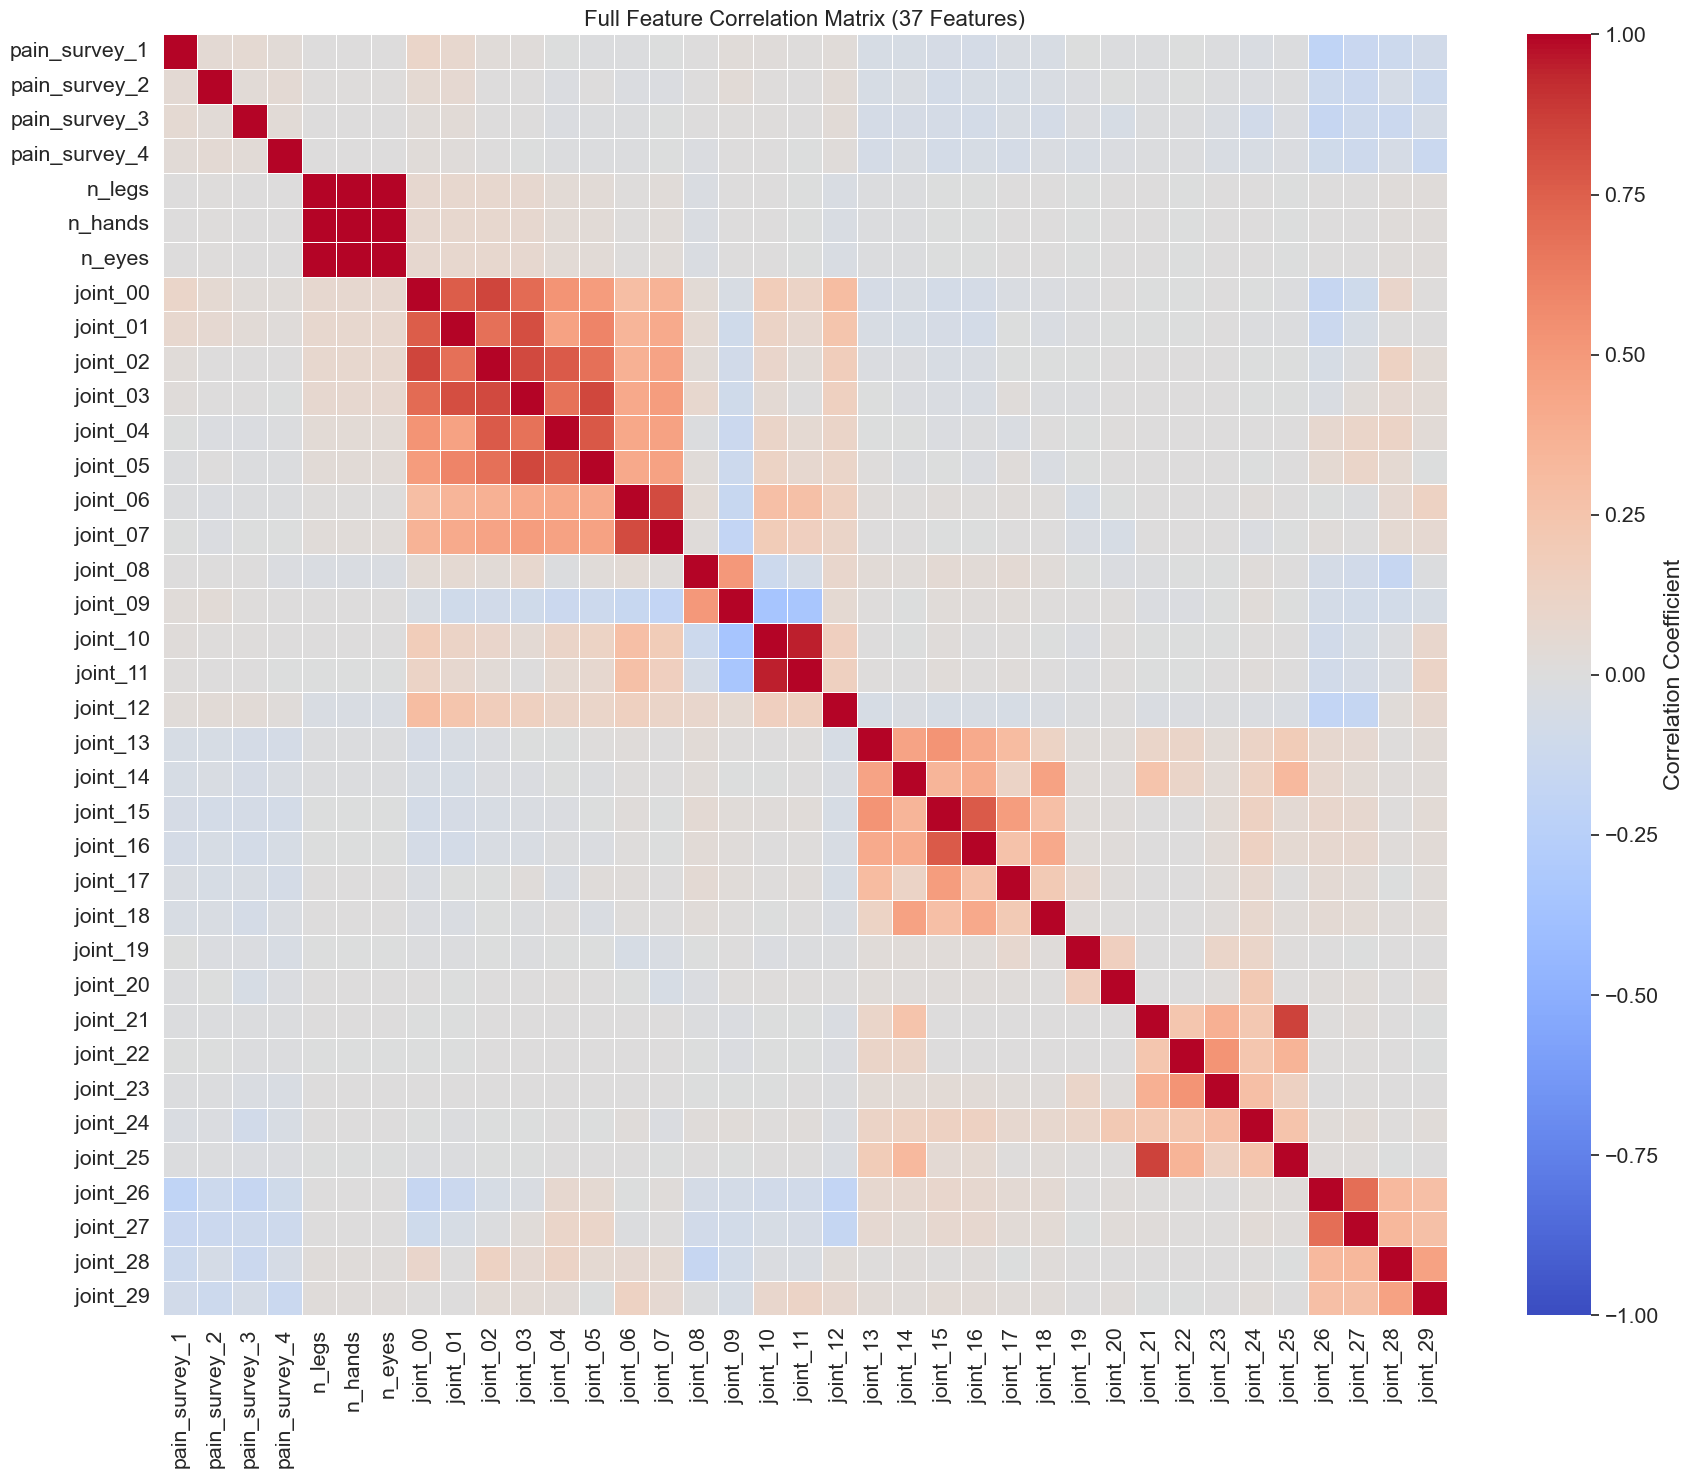

In [20]:
# features to correlate
features_to_correlate = X_train.drop(columns=['sample_index', 'time'])

# Correlation matrix
corr_matrix = features_to_correlate.corr()

# Plot the heatmap
plt.figure(figsize=(18, 15))
sns.heatmap(
    corr_matrix,
    annot=False,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    cbar_kws={'label': 'Correlation Coefficient'},
    linewidths=0.5,
    linecolor='white'
)
plt.title('Full Feature Correlation Matrix (37 Features)', fontsize=16)
plt.tight_layout()
plt.show()

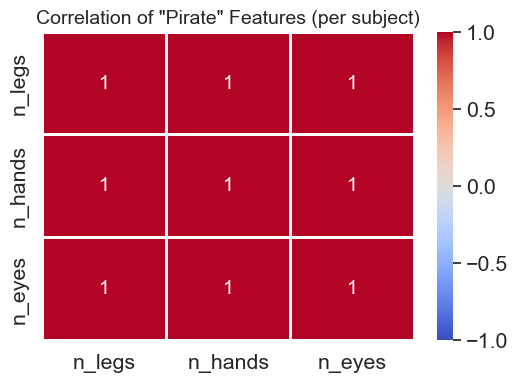

In [21]:
# Focus on "pirate features"
pirate_cols = ['n_legs', 'n_hands', 'n_eyes']

# Get one row per subject (sample_index)
subject_data = X_train.drop_duplicates(subset=['sample_index'])

# Calculate the correlation matrix for just these 3 features
pirate_corr = subject_data[pirate_cols].corr()

# Plot the heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(
    pirate_corr,
    annot=True,
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    linewidths=1,
    linecolor='white'
)
plt.title('Correlation of "Pirate" Features (per subject)', fontsize=14)
plt.show()

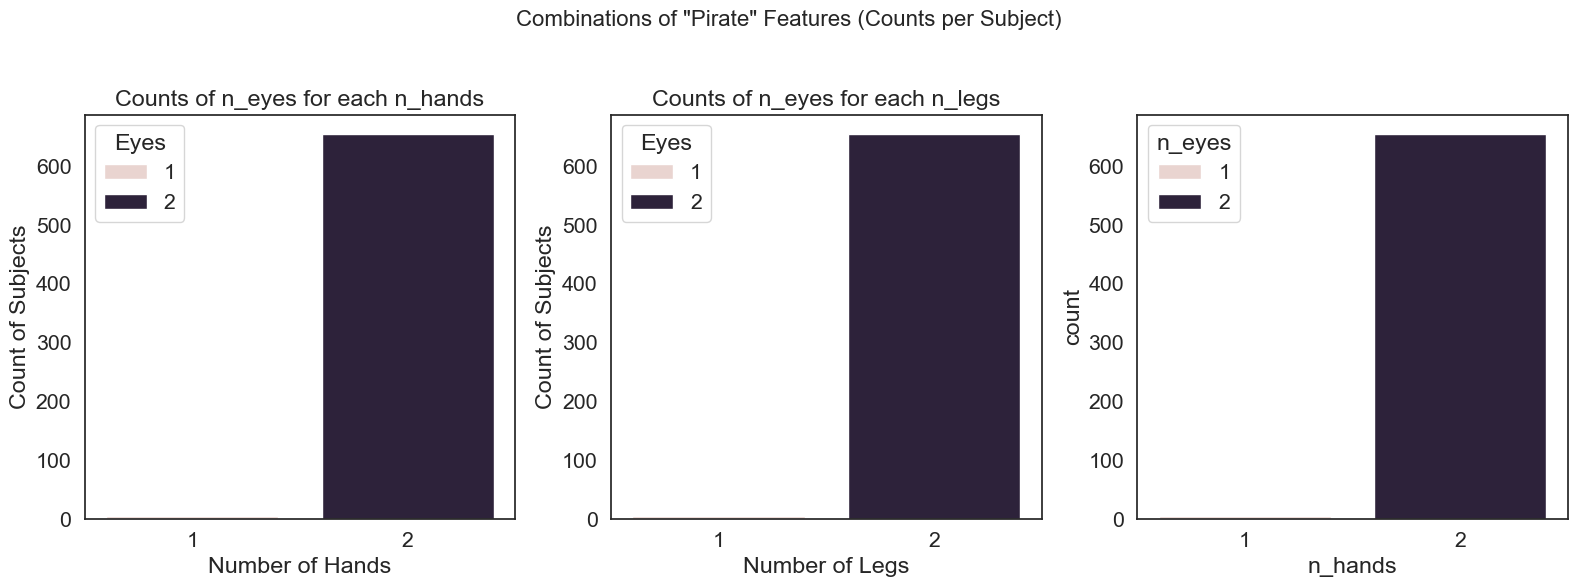


--- Crosstab: Legs vs. Hands ---
n_hands  1    2
n_legs         
1        6    0
2        0  655

--- Crosstab: Legs vs. Eyes ---
n_eyes  1    2
n_legs        
1       6    0
2       0  655

--- Crosstab: Hands vs. Eyes ---
n_eyes   1    2
n_hands        
1        6    0
2        0  655


In [22]:
# Get one row per subject (sample_index)
# We must use .drop_duplicates() to look at the 661 subjects
subject_data = X_train.drop_duplicates(subset=['sample_index'])

# Create Grouped Bar Charts
fig, axes = plt.subplots(1, 3, figsize=(16, 6))
fig.suptitle('Combinations of "Pirate" Features (Counts per Subject)', fontsize=16)

# Plot 1: Legs vs. Hands
sns.countplot(
    data=subject_data,
    x='n_legs',      # X-axis is 'n_legs' (1 or 2)
    hue='n_hands',     # Color is 'n_hands' (1 or 2)
    ax=axes[0]
)
axes[0].set_title('Counts of n_hands for each n_legs')
axes[0].set_xlabel('Number of Legs')
axes[0].set_ylabel('Count of Subjects')
axes[0].legend(title='Hands')

# Plot 2: Legs vs. Eyes
sns.countplot(
    data=subject_data,
    x='n_legs',      # X-axis is 'n_legs' (1 or 2)
    hue='n_eyes',      # Color is 'n_eyes' (1 or 2)
    ax=axes[1]
)
axes[1].set_title('Counts of n_eyes for each n_legs')
axes[1].set_xlabel('Number of Legs')
axes[1].set_ylabel('Count of Subjects')
axes[1].legend(title='Eyes')

# Plot 3: Hands vs. Eyes
sns.countplot(
    data=subject_data,
    x='n_hands',      # X-axis is 'n_hands' (1 or 2)
    hue='n_eyes',     # Color is 'n_eyes' (1 or 2)
    ax=axes[2]
)
axes[0].set_title('Counts of n_eyes for each n_hands')
axes[0].set_xlabel('Number of Hands')
axes[0].set_ylabel('Count of Subjects')
axes[0].legend(title='Eyes')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Show the Raw Numbers with a Crosstab
print("\n--- Crosstab: Legs vs. Hands ---")
print(pd.crosstab(subject_data['n_legs'], subject_data['n_hands']))

print("\n--- Crosstab: Legs vs. Eyes ---")
print(pd.crosstab(subject_data['n_legs'], subject_data['n_eyes']))

print("\n--- Crosstab: Hands vs. Eyes ---")
print(pd.crosstab(subject_data['n_hands'], subject_data['n_eyes']))

# Feature Engineering

In [23]:
# We know that n_legs=1 means they are a pirate, and n_legs=2 means they are not.
# We will create a new feature: 1 for pirate, 0 for not pirate.
X_train['is_pirate'] = (X_train['n_legs'] == 1).astype(int)
X_test['is_pirate'] = (X_test['n_legs'] == 1).astype(int)

# Drop the original 3 redundant features
features_to_drop = ['n_legs', 'n_hands', 'n_eyes']
X_train = X_train.drop(columns=features_to_drop)
X_test = X_test.drop(columns=features_to_drop)

print("Feature Engineering complete.")
print(f"Created 'is_pirate' feature and dropped 3 redundant columns.")
print(f"X_train 'is_pirate' counts (per subject):")
# We divide by 160 (timesteps) to see the count of subjects
print(X_train['is_pirate'].value_counts() / 160)

Feature Engineering complete.
Created 'is_pirate' feature and dropped 3 redundant columns.
X_train 'is_pirate' counts (per subject):
is_pirate
0    655.0
1      6.0
Name: count, dtype: float64


In [24]:
# Define the Final Feature List
# Get all remaining features (everything except the identifiers)
final_feature_cols = X_train.drop(columns=['sample_index', 'time']).columns.tolist()

FINAL_NUM_FEATURES = len(final_feature_cols)
print(f"Reshaping data with {FINAL_NUM_FEATURES} features...")

# Reshape X_train and X_test (This creates X_train_3d)
train_sequences = [
    df[final_feature_cols].values 
    for _, df in X_train.groupby('sample_index')
]
X_train_3d = np.stack(train_sequences) 

test_sequences = [
    df[final_feature_cols].values 
    for _, df in X_test.groupby('sample_index')
]
X_test_3d = np.stack(test_sequences)

# Encode y_train Labels
le = LabelEncoder()
y_train_sorted = y_train.sort_values(by='sample_index')
y_train_encoded = le.fit_transform(y_train_sorted['label'])

print("Reshaping and encoding done.")
print(f"X_train 3D shape: {X_train_3d.shape}")
print(f"y_train_encoded shape: {y_train_encoded.shape}")
print(f"Label mapping: {dict(zip(le.classes_, le.transform(le.classes_)))}")

Reshaping data with 35 features...
Reshaping and encoding done.
X_train 3D shape: (661, 160, 35)
y_train_encoded shape: (661,)
Label mapping: {'high_pain': np.int64(0), 'low_pain': np.int64(1), 'no_pain': np.int64(2)}


# Train & Validation data split

In [25]:
X_train_pre, X_val_pre, y_train_final, y_val_final = train_test_split(
    X_train_3d,
    y_train_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_train_encoded
)

print("Train/Validation split created.")
print(f"Training features shape:   {X_train_pre.shape}")
print(f"Validation features shape: {X_val_pre.shape}")
print(f"Training labels shape:   {y_train_final.shape}")
print(f"Validation labels shape: {y_val_final.shape}")

Train/Validation split created.
Training features shape:   (528, 160, 35)
Validation features shape: (133, 160, 35)
Training labels shape:   (528,)
Validation labels shape: (133,)


# Normalization

In [26]:
# Reshape data
n_samples_train, n_timesteps, n_features = X_train_pre.shape
n_samples_val = X_val_pre.shape[0]
n_samples_test = X_test_3d.shape[0] 

X_train_2d = X_train_pre.reshape(-1, n_features)
X_val_2d = X_val_pre.reshape(-1, n_features)
X_test_2d = X_test_3d.reshape(-1, n_features)

# Fit and apply StandardScaler
scaler = StandardScaler()
scaler.fit(X_train_2d) # Fit scaler on the (un-clipped) training data
print("StandardScaler fitted on training data.")

# Transform all three datasets
X_train_2d_scaled = scaler.transform(X_train_2d)
X_val_2d_scaled = scaler.transform(X_val_2d)
X_test_2d_scaled = scaler.transform(X_test_2d)

# Reshape back to 3D
X_train_final = X_train_2d_scaled.reshape(n_samples_train, n_timesteps, n_features)
X_val_final = X_val_2d_scaled.reshape(n_samples_val, n_timesteps, n_features)
X_test_final = X_test_2d_scaled.reshape(n_samples_test, n_timesteps, n_features)

print("StandardScaler complete.")


StandardScaler fitted on training data.
StandardScaler complete.


# Model Building

In [27]:
# Convert to Tensors (and to float32)
X_train_tensor = torch.tensor(X_train_final, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_final, dtype=torch.long)

X_val_tensor = torch.tensor(X_val_final, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_final, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_final, dtype=torch.float32)

# Create Datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor) # Test set has no labels

# Calculate Sampler Weights (the imbalance fix)
# Get the raw labels from your split training set
labels_for_sampling = y_train_final 

# Count class frequencies
class_counts = np.bincount(labels_for_sampling)
# Get weights (1.0 / count)
class_weights = 1. / class_counts
# Create a weight for every single sample* in the train_dataset
sample_weights = np.array([class_weights[label] for label in labels_for_sampling])
sampler = WeightedRandomSampler(
    weights=torch.DoubleTensor(sample_weights),
    num_samples=len(sample_weights)
)

# Create DataLoaders
BATCH_SIZE = 16
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    sampler=sampler,
    shuffle=False
)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("DataLoaders ready.")
print("Training batches will be class-balanced by the sampler.")
print(f"Batch size is set to: {BATCH_SIZE}")

DataLoaders ready.
Training batches will be class-balanced by the sampler.
Batch size is set to: 16


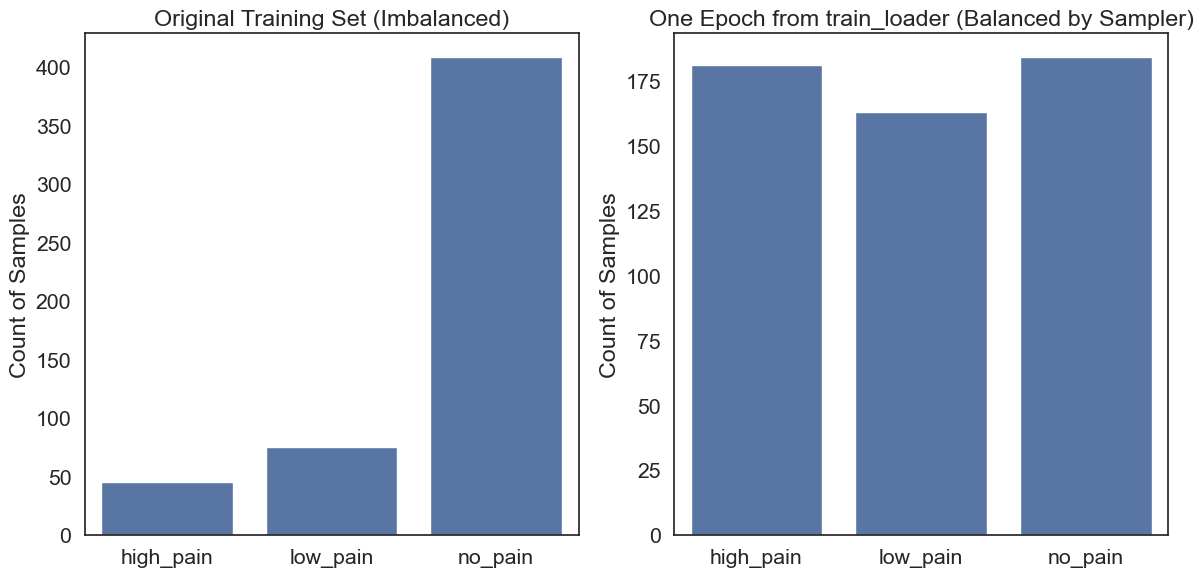

--- Original Class Counts (y_train_final) ---
Class high_pain: 45 samples
Class low_pain: 75 samples
Class no_pain: 408 samples

--- Sampled Loader Class Counts (One Epoch) ---
Class high_pain: 181 samples
Class low_pain: 163 samples
Class no_pain: 184 samples


In [28]:
# Get all labels from one epoch of the DataLoader
all_labels_from_loader = []
for data, labels in train_loader:
    all_labels_from_loader.extend(labels.cpu().numpy())

# Count the occurrences of each class
class_counts_loader = np.bincount(all_labels_from_loader)
class_names = le.classes_ # From your Step 2

# Plot the comparison
plt.figure(figsize=(12, 6))

# Subplot 1: Original Imbalance
plt.subplot(1, 2, 1)
original_counts = np.bincount(y_train_final)
sns.barplot(x=list(class_names), y=original_counts)
plt.title('Original Training Set (Imbalanced)')
plt.ylabel('Count of Samples')

# Subplot 2: Loader Batch
plt.subplot(1, 2, 2)
sns.barplot(x=list(class_names), y=class_counts_loader)
plt.title('One Epoch from train_loader (Balanced by Sampler)')
plt.ylabel('Count of Samples')

plt.tight_layout()
plt.show()

# Print the numbers
print("--- Original Class Counts (y_train_final) ---")
for i, count in enumerate(original_counts):
    print(f"Class {le.inverse_transform([i])[0]}: {count} samples")

print("\n--- Sampled Loader Class Counts (One Epoch) ---")
for i, count in enumerate(class_counts_loader):
    print(f"Class {le.inverse_transform([i])[0]}: {count} samples")

In [29]:
os.makedirs("models", exist_ok=True)
def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda=0, l2_lambda=0):
    model.train()
    running_loss = 0.0
    all_predictions = []
    all_targets = []
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            logits = model(inputs)
            loss = criterion(logits, targets)
            if l1_lambda > 0: loss = loss + l1_lambda * sum(p.abs().sum() for p in model.parameters())
            if l2_lambda > 0: loss = loss + l2_lambda * sum(p.pow(2).sum() for p in model.parameters())
        if scaler.is_enabled():
            scaler.scale(loss).backward(); scaler.step(optimizer); scaler.update()
        else:
            loss.backward(); optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        predictions = logits.argmax(dim=1)
        all_predictions.append(predictions.cpu().numpy())
        all_targets.append(targets.cpu().numpy())
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_f1 = f1_score(np.concatenate(all_targets), np.concatenate(all_predictions), average='macro', zero_division=0)
    return epoch_loss, epoch_f1

In [30]:
def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                logits = model(inputs); loss = criterion(logits, targets)
            running_loss += loss.item() * inputs.size(0)
            predictions = logits.argmax(dim=1)
            all_predictions.append(predictions.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_f1 = f1_score(np.concatenate(all_targets), np.concatenate(all_predictions), average='macro', zero_division=0)
    return epoch_loss, epoch_f1

def fit(model, train_loader, val_loader, epochs, criterion, optimizer, scaler, device,
        l1_lambda=0, l2_lambda=0, patience=0, evaluation_metric="val_f1", mode='max',
        restore_best_weights=True, verbose=1, experiment_name=""):
    training_history = {'train_loss': [], 'val_loss': [], 'train_f1': [], 'val_f1': []}
    if patience > 0:
        patience_counter = 0; best_metric = float('-inf') if mode == 'max' else float('inf'); best_epoch = 0
    model_save_path = f"models/{experiment_name}_best_model.pt"
    for epoch in range(1, epochs + 1):
        train_loss, train_f1 = train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, l1_lambda, l2_lambda)
        val_loss, val_f1 = validate_one_epoch(model, val_loader, criterion, device)
        training_history['train_loss'].append(train_loss); training_history['val_loss'].append(val_loss)
        training_history['train_f1'].append(train_f1); training_history['val_f1'].append(val_f1)
        if verbose > 0 and (epoch % verbose == 0 or epoch == 1): print(f"Epoch {epoch:3d}/{epochs} | Train: F1={train_f1:.4f} | Val: F1={val_f1:.4f}")
        if patience > 0:
            current_metric = training_history[evaluation_metric][-1]
            is_improvement = (current_metric > best_metric) if mode == 'max' else (current_metric < best_metric)
            if is_improvement:
                best_metric = current_metric; best_epoch = epoch; torch.save(model.state_dict(), model_save_path); patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= patience: print(f"Early stopping triggered after {epoch} epochs."); break
    if restore_best_weights and patience > 0:
        print(f"Best model restored from epoch {best_epoch} with {evaluation_metric} {best_metric:.4f}")
        try: model.load_state_dict(torch.load(model_save_path, map_location=device))
        except FileNotFoundError: print(f"Warning: Could not find best model to restore.")
    return model, training_history

# Model Training

# 1D CNN

In [31]:
class SimplePirateCNN(nn.Module):
    def __init__(self, input_features, num_classes, dropout_rate=0.25):
        super().__init__()
        self.permute = lambda x: x.permute(0, 2, 1)
        
        # Only one conv block
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(in_channels=input_features, out_channels=64, kernel_size=7, padding=3),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(kernel_size=2)
        )
        
        # Pool and classify
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        
        # Classifier head with dropout
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate), 
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.permute(x)
        x = self.conv_block1(x)
        x = self.avg_pool(x)
        x = self.flatten(x)
        logits = self.classifier(x)
        return logits

print("Model class 'SimplePirateCNN' defined.")

Model class 'SimplePirateCNN' defined.


In [32]:
# Train the SimplePirateCNN Model
MODEL_NAME = "SimplePirateCNN"
model = SimplePirateCNN(
    input_features=FINAL_NUM_FEATURES,
    num_classes=3, 
    dropout_rate=0.5
).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1) 
optimizer = optim.RMSprop(model.parameters(), lr=1e-3, weight_decay=0.0)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))

# Run it
model, history_simple_cnn = fit(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=200,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    l1_lambda=0,
    l2_lambda=1e-4,
    patience=40,
    experiment_name=MODEL_NAME
)

Epoch   1/200 | Train: F1=0.6019 | Val: F1=0.6200
Epoch   2/200 | Train: F1=0.6761 | Val: F1=0.6925
Epoch   3/200 | Train: F1=0.7348 | Val: F1=0.6879
Epoch   4/200 | Train: F1=0.7828 | Val: F1=0.7395
Epoch   5/200 | Train: F1=0.8058 | Val: F1=0.8026
Epoch   6/200 | Train: F1=0.7992 | Val: F1=0.7512
Epoch   7/200 | Train: F1=0.8135 | Val: F1=0.7445
Epoch   8/200 | Train: F1=0.8386 | Val: F1=0.7655
Epoch   9/200 | Train: F1=0.8162 | Val: F1=0.7802
Epoch  10/200 | Train: F1=0.8641 | Val: F1=0.7947
Epoch  11/200 | Train: F1=0.8544 | Val: F1=0.8445
Epoch  12/200 | Train: F1=0.8559 | Val: F1=0.8008
Epoch  13/200 | Train: F1=0.8671 | Val: F1=0.7758
Epoch  14/200 | Train: F1=0.8499 | Val: F1=0.7984
Epoch  15/200 | Train: F1=0.8502 | Val: F1=0.7866
Epoch  16/200 | Train: F1=0.8775 | Val: F1=0.8234
Epoch  17/200 | Train: F1=0.8788 | Val: F1=0.8137
Epoch  18/200 | Train: F1=0.8842 | Val: F1=0.8507
Epoch  19/200 | Train: F1=0.8436 | Val: F1=0.8086
Epoch  20/200 | Train: F1=0.9089 | Val: F1=0.8568


# 2D CNN

In [33]:
class PirateCNN(nn.Module):
    def __init__(self, input_features, num_classes, dropout_rate=0.5):
        super().__init__()
        self.permute = lambda x: x.permute(0, 2, 1)
        
        self.conv_block1 = nn.Sequential(
            nn.Conv1d(in_channels=input_features, out_channels=64, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(kernel_size=2)
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(kernel_size=2)
        )
        
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.flatten = nn.Flatten()
        
        # Droupout
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate), # Add dropout layer
            nn.Linear(128, num_classes) # Final classification
        )

    def forward(self, x):
        x = self.permute(x)
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.avg_pool(x)
        x = self.flatten(x)
        logits = self.classifier(x) # Pass through new classifier block
        return logits

In [34]:
# Define FocalLoss Class
class FocalLoss(nn.Module):
    """
    Implements Focal Loss (gamma=2.0).
    """
    def __init__(self, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        # Use a fixed alpha of 0.25 (a common default)
        focal_loss = 0.25 * (1 - pt)**self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        else:
            return focal_loss

# Define Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"FocalLoss class defined. Using device: {device}")

FocalLoss class defined. Using device: cpu


In [35]:
# Run the model with RMSprop and Focal Loss

MODEL_NAME = "CNN_RMS_FocalLoss"

model = PirateCNN(
    input_features=FINAL_NUM_FEATURES,
    num_classes=3, 
    dropout_rate=0.3
).to(device)

# Loss: Focal Loss
criterion = FocalLoss(gamma=2.0) 

# Optimizer: RMSprop
optimizer = optim.RMSprop(
    model.parameters(), 
    lr=1e-4, 
    momentum=0.9,
    weight_decay=0.0
)

scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))

# Run the training
model, history_rms_fl = fit(
    model=model,
    train_loader=train_loader, # <-- Uses the SHUFFLED loader
    val_loader=val_loader,
    epochs=200,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    l1_lambda=0,
    l2_lambda=1e-5,
    patience=40,
    experiment_name=MODEL_NAME
)

Epoch   1/200 | Train: F1=0.5983 | Val: F1=0.6095
Epoch   2/200 | Train: F1=0.7667 | Val: F1=0.6844
Epoch   3/200 | Train: F1=0.8306 | Val: F1=0.6577
Epoch   4/200 | Train: F1=0.8638 | Val: F1=0.6490
Epoch   5/200 | Train: F1=0.8828 | Val: F1=0.6812
Epoch   6/200 | Train: F1=0.8733 | Val: F1=0.7256
Epoch   7/200 | Train: F1=0.8961 | Val: F1=0.6912
Epoch   8/200 | Train: F1=0.9032 | Val: F1=0.6965
Epoch   9/200 | Train: F1=0.8944 | Val: F1=0.7398
Epoch  10/200 | Train: F1=0.9133 | Val: F1=0.7471
Epoch  11/200 | Train: F1=0.9342 | Val: F1=0.6672
Epoch  12/200 | Train: F1=0.9042 | Val: F1=0.7687
Epoch  13/200 | Train: F1=0.9464 | Val: F1=0.7015
Epoch  14/200 | Train: F1=0.9582 | Val: F1=0.7589
Epoch  15/200 | Train: F1=0.9467 | Val: F1=0.7303
Epoch  16/200 | Train: F1=0.9386 | Val: F1=0.6618
Epoch  17/200 | Train: F1=0.9487 | Val: F1=0.7163
Epoch  18/200 | Train: F1=0.9585 | Val: F1=0.6930
Epoch  19/200 | Train: F1=0.9270 | Val: F1=0.6959
Epoch  20/200 | Train: F1=0.9679 | Val: F1=0.7176


# 1D CNN with Adam optimizer and Focal Loss

In [36]:
# Create DataLoaders (Standard Shuffle for FocalLoss)
BATCH_SIZE = 16

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# We now use a standard shuffled DataLoader, instead the sampler.
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
print("DataLoaders reset to standard shuffle (for Focal Loss experiment).")

DataLoaders reset to standard shuffle (for Focal Loss experiment).


In [37]:
# Run the model PirateCNN_Adam_FocalLoss

EXPERIMENT_NAME = "PirateCNN_Adam_FocalLoss"
model = PirateCNN(
    input_features=FINAL_NUM_FEATURES,
    num_classes=3, 
    dropout_rate=0.25
).to(device)

# Loss: Focal Loss
criterion = FocalLoss(gamma=2.0) 

# Optimizer: Adam
optimizer = optim.Adam(
    model.parameters(), 
    lr=1e-3,
    weight_decay=0.0 # Set to 0, L2 is handled by fit()
)

scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))

# Run the training
model, history_adam_focal = fit(
    model=model,
    train_loader=train_loader, # Uses the shuffled loader
    val_loader=val_loader,
    epochs=200,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    l1_lambda=0,
    l2_lambda=1e-4,
    patience=20,
    experiment_name=EXPERIMENT_NAME
)

Epoch   1/200 | Train: F1=0.4759 | Val: F1=0.6946
Epoch   2/200 | Train: F1=0.6563 | Val: F1=0.8350
Epoch   3/200 | Train: F1=0.7160 | Val: F1=0.7257
Epoch   4/200 | Train: F1=0.7941 | Val: F1=0.7033
Epoch   5/200 | Train: F1=0.7841 | Val: F1=0.6588
Epoch   6/200 | Train: F1=0.7850 | Val: F1=0.7455
Epoch   7/200 | Train: F1=0.8191 | Val: F1=0.7188
Epoch   8/200 | Train: F1=0.8450 | Val: F1=0.7771
Epoch   9/200 | Train: F1=0.8616 | Val: F1=0.6517
Epoch  10/200 | Train: F1=0.8761 | Val: F1=0.7139
Epoch  11/200 | Train: F1=0.8784 | Val: F1=0.8039
Epoch  12/200 | Train: F1=0.8496 | Val: F1=0.6354
Epoch  13/200 | Train: F1=0.9140 | Val: F1=0.6834
Epoch  14/200 | Train: F1=0.9206 | Val: F1=0.7267
Epoch  15/200 | Train: F1=0.9120 | Val: F1=0.7390
Epoch  16/200 | Train: F1=0.9010 | Val: F1=0.7799
Epoch  17/200 | Train: F1=0.9237 | Val: F1=0.6246
Epoch  18/200 | Train: F1=0.9313 | Val: F1=0.7393
Epoch  19/200 | Train: F1=0.9309 | Val: F1=0.7088
Epoch  20/200 | Train: F1=0.9285 | Val: F1=0.7399


In [38]:
class Pirate2DCNN(nn.Module):
    def __init__(self, input_features, num_classes, dropout_rate=0.25):
        super().__init__()
        # We need to add a "channel" dimension: (B, T, F) -> (B, 1, T, F)
        self.unsqueeze = lambda x: x.unsqueeze(1)
        
        # 2D CONV BLOCK 1
        # 1 input channel, 32 output filters
        # Kernel slides 5 steps in time and 5 steps across features
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(5, 5), padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=(2, 2)) # Halves time and features
        )
        
        # 2D CONV BLOCK 2
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=(2, 2)) # Halves time and features again
        )
        
        # Pool and Classify
        self.avg_pool = nn.AdaptiveAvgPool2d(1) # Pool to (B, 64, 1, 1)
        self.flatten = nn.Flatten()
        
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate), 
            nn.Linear(64, num_classes) # Final classifier
        )

    def forward(self, x):
        # x shape: (B, 160, 36)
        x = self.unsqueeze(x) # Shape: (B, 1, 160, 36)
        x = self.conv_block1(x) # Shape: (B, 32, 80, 18)
        x = self.conv_block2(x) # Shape: (B, 64, 40, 9)
        x = self.avg_pool(x)  # Shape: (B, 64, 1, 1)
        x = self.flatten(x)    # Shape: (B, 64)
        logits = self.classifier(x) # Shape: (B, 3)
        return logits

print("Model class 'Pirate2DCNN' (2D Convolutional) defined.")

Model class 'Pirate2DCNN' (2D Convolutional) defined.


In [39]:
# Run the 2D CNN model with Adam optimizer and Focal Loss

MODEL_NAME = "2D_CNN_Adam_FocalLoss"
model = Pirate2DCNN(
    input_features=FINAL_NUM_FEATURES,
    num_classes=3, 
    dropout_rate=0.3
).to(device)

# Loss: Focal Loss
criterion = FocalLoss(gamma=2.0) 

# Optimizer: Adam
optimizer = optim.Adam(
    model.parameters(), 
    lr=1e-3, 
    weight_decay=0.0 # Set to 0, L2 is handled by fit()
)

scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))

# Run the training
model, history_2d_cnn_focal = fit(
    model=model,
    train_loader=train_loader, # Uses the shuffled loader
    val_loader=val_loader,
    epochs=200,
    criterion=criterion,
    optimizer=optimizer,
    scaler=scaler,
    device=device,
    l1_lambda=0,
    l2_lambda=1e-4,
    patience=20,
    experiment_name=MODEL_NAME
)

Epoch   1/200 | Train: F1=0.4071 | Val: F1=0.4087
Epoch   2/200 | Train: F1=0.4555 | Val: F1=0.3739
Epoch   3/200 | Train: F1=0.4741 | Val: F1=0.3777
Epoch   4/200 | Train: F1=0.4876 | Val: F1=0.5866
Epoch   5/200 | Train: F1=0.4957 | Val: F1=0.6120
Epoch   6/200 | Train: F1=0.5759 | Val: F1=0.7092
Epoch   7/200 | Train: F1=0.5781 | Val: F1=0.6485
Epoch   8/200 | Train: F1=0.5757 | Val: F1=0.7137
Epoch   9/200 | Train: F1=0.6262 | Val: F1=0.7864
Epoch  10/200 | Train: F1=0.6767 | Val: F1=0.7307
Epoch  11/200 | Train: F1=0.6483 | Val: F1=0.7857
Epoch  12/200 | Train: F1=0.7284 | Val: F1=0.7562
Epoch  13/200 | Train: F1=0.7346 | Val: F1=0.6994
Epoch  14/200 | Train: F1=0.7405 | Val: F1=0.7689
Epoch  15/200 | Train: F1=0.7210 | Val: F1=0.7201
Epoch  16/200 | Train: F1=0.7479 | Val: F1=0.7183
Epoch  17/200 | Train: F1=0.7046 | Val: F1=0.7127
Epoch  18/200 | Train: F1=0.7586 | Val: F1=0.7568
Epoch  19/200 | Train: F1=0.7733 | Val: F1=0.7943
Epoch  20/200 | Train: F1=0.7773 | Val: F1=0.7681


KeyboardInterrupt: 

# K-Shuffle-Split Cross Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold

# Prepare full dataset variables
X_train_full = X_train_3d
y_train_full = y_train_encoded
# This is the full, un-split, 3D test set
X_test_3d_full = X_test_3d 
print("Full dataset variables are now defined.")

# # Define the Model Class (SimplePirateCNN)
# class SimplePirateCNN(nn.Module):
#     def __init__(self, input_features, num_classes, dropout_rate=0.25):
#         super().__init__()
#         self.permute = lambda x: x.permute(0, 2, 1)
#         self.conv_block1 = nn.Sequential(
#             nn.Conv1d(in_channels=input_features, out_channels=64, kernel_size=7, padding=3),
#             nn.ReLU(),
#             nn.BatchNorm1d(64),
#             nn.MaxPool1d(kernel_size=2)
#         )
#         self.avg_pool = nn.AdaptiveAvgPool1d(1)
#         self.flatten = nn.Flatten()
#         self.classifier = nn.Sequential(
#             nn.Dropout(p=dropout_rate), 
#             nn.Linear(64, num_classes)
#         )
#     def forward(self, x):
#         x = self.permute(x)
#         x = self.conv_block1(x)
#         x = self.avg_pool(x)
#         x = self.flatten(x)
#         logits = self.classifier(x)
#         return logits
# print("Model class 'SimplePirateCNN' is now defined.")


# K-Fold Setup (the hyperparameters
K_FOLDS = 5
EPOCHS = 150  
PATIENCE = 30
BATCH_SIZE = 16
DROPOUT_RATE = 0.2
L2_LAMBDA = 0.0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
fold_scores = [] 
best_epochs_list = [] 

print(f"--- Starting {K_FOLDS}-Fold Cross-Validation ---")
print(f"MODEL: SimplePirateCNN (D=0.2, L2=0, B=16)")
print(f"NORMALIZATION: StandardScaler ONLY (No Clipping)")

# Start the Loop
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_full, y_train_full)):
    print(f"\n--- FOLD {fold + 1}/{K_FOLDS} ---")
    
    # Get data, normalize (StandardScaler)
    X_train_fold, y_train_fold = X_train_full[train_idx], y_train_full[train_idx]
    X_val_fold, y_val_fold = X_train_full[val_idx], y_train_full[val_idx]

    n_samples_train, n_timesteps, n_features = X_train_fold.shape
    X_train_2d = X_train_fold.reshape(-1, n_features)
    X_val_2d = X_val_fold.reshape(-1, n_features)
    
    # StandardScaler
    scaler = StandardScaler()
    X_train_2d_scaled = scaler.fit_transform(X_train_2d)
    X_val_2d_scaled = scaler.transform(X_val_2d)
    
    X_train_fold_final = X_train_2d_scaled.reshape(X_train_fold.shape)
    X_val_fold_final = X_val_2d_scaled.reshape(X_val_fold.shape)

    # Create DataLoaders with Sampler
    X_train_tensor = torch.tensor(X_train_fold_final, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_fold, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val_fold_final, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_fold, dtype=torch.long)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    
    class_counts = np.bincount(y_train_fold)
    class_weights = 1. / class_counts
    sample_weights = np.array([class_weights[label] for label in y_train_fold])
    sampler = WeightedRandomSampler(torch.DoubleTensor(sample_weights), len(sample_weights))
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize a fresh model for this fold
    model = SimplePirateCNN(
        input_features=FINAL_NUM_FEATURES, 
        num_classes=3, 
        dropout_rate=DROPOUT_RATE
    ).to(device)
    
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1) 
    optimizer = optim.RMSprop(model.parameters(), lr=1e-3, weight_decay=0.0)
    scaler_amp = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))

    # Train
    experiment_name = f"Fold_{fold+1}_SimpleCNN_D02_L0"
    model, history = fit(
        model=model, train_loader=train_loader, val_loader=val_loader,
        epochs=EPOCHS, criterion=criterion, optimizer=optimizer, scaler=scaler_amp,
        device=device, l1_lambda=0, l2_lambda=L2_LAMBDA, 
        patience=PATIENCE, experiment_name=experiment_name, verbose=10
    )
    
    # Save results
    best_fold_f1 = max(history['val_f1'])
    best_epoch_num = np.argmax(history['val_f1']) + 1 
    fold_scores.append(best_fold_f1)
    best_epochs_list.append(best_epoch_num)
    print(f"--- Fold {fold + 1} Best Val F1: {best_fold_f1:.4f} at epoch {best_epoch_num} ---")

# Final K-Fold Results
print("\n" + "="*40)
print(f"--- K-Fold Complete (D=0.2, L2=0, B=16) ---")
print(f"F1 Scores for each fold: {np.round(fold_scores, 4)}")
print(f"Best Epochs for each fold: {best_epochs_list}")
print(f"Average Val F1: {np.mean(fold_scores):.4f}")
print(f"Std Dev of Val F1: {np.std(fold_scores):.4f}")
print("="*40)

Full dataset variables are now defined.
--- Starting 5-Fold Cross-Validation ---
MODEL: SimplePirateCNN (D=0.2, L2=0, B=16)
NORMALIZATION: StandardScaler ONLY (No Clipping)

--- FOLD 1/5 ---
Epoch   1/150 | Train: F1=0.5991 | Val: F1=0.5798
Epoch  10/150 | Train: F1=0.8882 | Val: F1=0.7776
Epoch  20/150 | Train: F1=0.9344 | Val: F1=0.8093
Epoch  30/150 | Train: F1=0.9452 | Val: F1=0.8334
Epoch  40/150 | Train: F1=0.9486 | Val: F1=0.8505
Epoch  50/150 | Train: F1=0.9655 | Val: F1=0.8292
Epoch  60/150 | Train: F1=0.9602 | Val: F1=0.8624
Epoch  70/150 | Train: F1=0.9738 | Val: F1=0.8658
Early stopping triggered after 75 epochs.
Best model restored from epoch 45 with val_f1 0.8846
--- Fold 1 Best Val F1: 0.8846 at epoch 45 ---

--- FOLD 2/5 ---
Epoch   1/150 | Train: F1=0.6588 | Val: F1=0.6039
Epoch  10/150 | Train: F1=0.9164 | Val: F1=0.7265
Epoch  20/150 | Train: F1=0.9241 | Val: F1=0.7559
Epoch  30/150 | Train: F1=0.9619 | Val: F1=0.7029
Epoch  40/150 | Train: F1=0.9596 | Val: F1=0.7491

In [ ]:
# class PirateCNN(nn.Module):
#     def __init__(self, input_features, num_classes, dropout_rate=0.25):
#         super().__init__()
#         self.permute = lambda x: x.permute(0, 2, 1)
#         self.conv_block1 = nn.Sequential(
#             nn.Conv1d(in_channels=input_features, out_channels=64, kernel_size=5, padding=2),
#             nn.ReLU(), nn.BatchNorm1d(64), nn.MaxPool1d(kernel_size=2)
#         )
#         self.conv_block2 = nn.Sequential(
#             nn.Conv1d(in_channels=64, out_channels=128, kernel_size=5, padding=2),
#             nn.ReLU(), nn.BatchNorm1d(128), nn.MaxPool1d(kernel_size=2)
#         )
#         self.avg_pool = nn.AdaptiveAvgPool1d(1)
#         self.flatten = nn.Flatten()
#         self.classifier = nn.Sequential(
#             nn.Dropout(p=dropout_rate), 
#             nn.Linear(128, num_classes)
#         )
#     def forward(self, x):
#         x = self.permute(x); x = self.conv_block1(x); x = self.conv_block2(x)
#         x = self.avg_pool(x); x = self.flatten(x); logits = self.classifier(x)
#         return logits
# print("Model class 'PirateCNN' (2-block) defined.")
from sklearn.model_selection import StratifiedKFold

# Prepare full dataset variables
X_train_full = X_train_3d
y_train_full = y_train_encoded
# This is the full, un-split, 3D test set
X_test_3d_full = X_test_3d 
print("Full dataset variables are now defined.")

# K-Fold Setup (the hyperparameters)
K_FOLDS = 5
EPOCHS = 200  
PATIENCE = 40 
BATCH_SIZE = 16
DROPOUT_RATE = 0.5
L2_LAMBDA = 1e-4
LEARNING_RATE = 1e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=42)
fold_scores = [] 
best_epochs_list = [] 

print(f"--- Starting {K_FOLDS}-Fold Cross-Validation ---")
print(f"MODEL: PirateCNN (D={DROPOUT_RATE})")
print(f"OPTIMIZER: RMSprop (LR={LEARNING_RATE})")
print(f"LOSS: FocalLoss")

# Start the Loop
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_full, y_train_full)):
    print(f"\n--- FOLD {fold + 1}/{K_FOLDS} ---")
    
    # Get data, normalize
    X_train_fold, y_train_fold = X_train_full[train_idx], y_train_full[train_idx]
    X_val_fold, y_val_fold = X_train_full[val_idx], y_train_full[val_idx]

    n_samples_train, n_timesteps, n_features = X_train_fold.shape
    X_train_2d = X_train_fold.reshape(-1, n_features)
    X_val_2d = X_val_fold.reshape(-1, n_features)
    
    scaler = StandardScaler()
    X_train_2d_scaled = scaler.fit_transform(X_train_2d)
    X_val_2d_scaled = scaler.transform(X_val_2d)
    
    X_train_fold_final = X_train_2d_scaled.reshape(X_train_fold.shape)
    X_val_fold_final = X_val_2d_scaled.reshape(X_val_fold.shape)

    # Create DataLoaders (Standard Shuffle for FocalLoss)
    X_train_tensor = torch.tensor(X_train_fold_final, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_fold, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val_fold_final, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val_fold, dtype=torch.long)

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    
    # Using standard shuffle
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

    # Initialize a fresh model for this fold
    model = PirateCNN(
        input_features=FINAL_NUM_FEATURES, 
        num_classes=3, 
        dropout_rate=DROPOUT_RATE
    ).to(device)
    
    criterion = FocalLoss(gamma=2.0) 
    optimizer = optim.RMSprop(
        model.parameters(), 
        lr=LEARNING_RATE, 
        momentum=0.9, 
        weight_decay=0.0
    )
    scaler_amp = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))

    # Train
    experiment_name = f"Fold_{fold+1}_PirateCNN_FocalLoss"
    model, history = fit(
        model=model, train_loader=train_loader, val_loader=val_loader,
        epochs=EPOCHS, criterion=criterion, optimizer=optimizer, scaler=scaler_amp,
        device=device, l1_lambda=0, l2_lambda=L2_LAMBDA, 
        patience=PATIENCE, experiment_name=experiment_name, verbose=10
    )
    
    # Save results
    best_fold_f1 = max(history['val_f1'])
    best_epoch_num = np.argmax(history['val_f1']) + 1 
    fold_scores.append(best_fold_f1)
    best_epochs_list.append(best_epoch_num)
    print(f"--- Fold {fold + 1} Best Val F1: {best_fold_f1:.4f} at epoch {best_epoch_num} ---")

# --- 10. Final K-Fold Results ---
print("\n" + "="*40)
print(f"--- K-Fold Complete (PirateCNN + FocalLoss + StandardScaler Only) ---")
print(f"F1 Scores for each fold: {np.round(fold_scores, 4)}")
print(f"Best Epochs for each fold: {best_epochs_list}")
print(f"Average Val F1: {np.mean(fold_scores):.4f}")
print(f"Std Dev of Val F1: {np.std(fold_scores):.4f}")
print("="*40)

--- Starting 5-Fold Cross-Validation ---
MODEL: PirateCNN (D=0.5)
OPTIMIZER: RMSprop (LR=0.0001)
LOSS: FocalLoss


NameError: name 'X_train_full' is not defined

--- Starting Final Model Training ---
Final scaler fitted and data transformed.
Final DataLoaders created.
Training final model for 69 epochs...
Epoch [10/69] | Train Loss: 0.4745 | Train F1: 0.9416
Epoch [20/69] | Train Loss: 0.4206 | Train F1: 0.9698
Epoch [30/69] | Train Loss: 0.4152 | Train F1: 0.9818
Epoch [40/69] | Train Loss: 0.4048 | Train F1: 0.9729
Epoch [50/69] | Train Loss: 0.3937 | Train F1: 0.9838
Epoch [60/69] | Train Loss: 0.3937 | Train F1: 0.9783
Epoch [69/69] | Train Loss: 0.3970 | Train F1: 0.9868
Final model training complete.


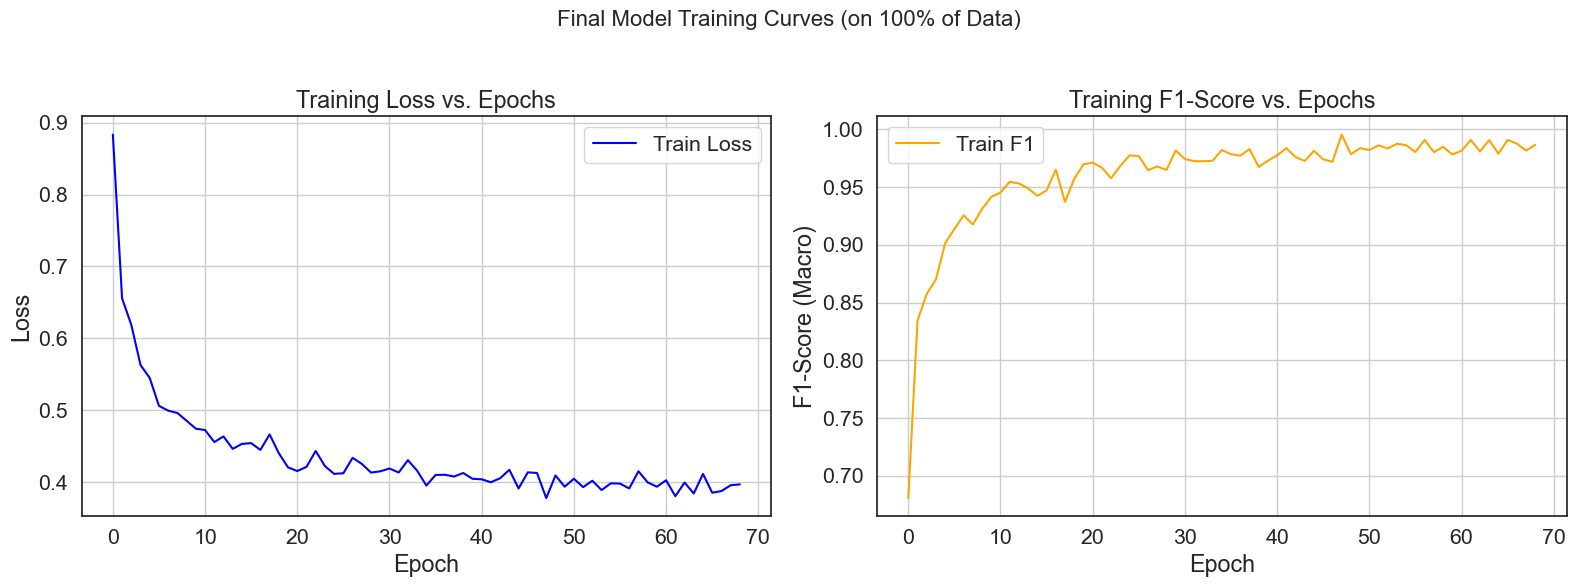

In [ ]:
# FINAL SETTINGS
FINAL_MODEL_CLASS = PirateCNN
FINAL_DROPOUT = 0.5
FINAL_L2 = 1e-4
FINAL_BATCH_SIZE = 16
FINAL_EPOCHS = int(np.mean(best_epochs_list)) # Avg best epoch from K-Fold
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"--- Starting Final Model Training ---")

# Normalize Full Data (Clip-and-Scale)
n_samples_train, n_timesteps, n_features = X_train_full.shape
n_samples_test = X_test_3d_full.shape[0]
X_train_2d = X_train_full.reshape(-1, n_features)
X_test_2d = X_test_3d_full.reshape(-1, n_features)
q_low = np.percentile(X_train_2d, 1, axis=0)
q_high = np.percentile(X_train_2d, 99, axis=0)
X_train_2d_clipped = np.clip(X_train_2d, q_low, q_high)
X_test_2d_clipped = np.clip(X_test_2d, q_low, q_high)
scaler = StandardScaler()
scaler.fit(X_train_2d_clipped)
X_train_2d_scaled = scaler.transform(X_train_2d_clipped)
X_test_2d_scaled = scaler.transform(X_test_2d_clipped)
X_train_final = X_train_2d_scaled.reshape(n_samples_train, n_timesteps, n_features)
X_test_final = X_test_2d_scaled.reshape(n_samples_test, n_timesteps, n_features)
print("Final scaler fitted and data transformed.")

# 3. Create Final DataLoaders (using Sampler)
X_train_tensor = torch.tensor(X_train_final, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_full, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_final, dtype=torch.float32)
train_dataset_final = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset_final = TensorDataset(X_test_tensor)

class_counts = np.bincount(y_train_full)
class_weights = 1. / class_counts
sample_weights = np.array([class_weights[label] for label in y_train_full])
sampler = WeightedRandomSampler(torch.DoubleTensor(sample_weights), len(sample_weights))

final_train_loader = DataLoader(train_dataset_final, batch_size=FINAL_BATCH_SIZE, sampler=sampler)
final_test_loader = DataLoader(test_dataset_final, batch_size=FINAL_BATCH_SIZE, shuffle=False)
print("Final DataLoaders created.")

# Train the Champion Model
final_model = FINAL_MODEL_CLASS(
    input_features=FINAL_NUM_FEATURES, 
    num_classes=3, 
    dropout_rate=FINAL_DROPOUT
).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1) 
optimizer = optim.RMSprop(final_model.parameters(), lr=1e-3, weight_decay=0.0)
scaler_amp = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))

# Create history dictionary
final_history = {'train_loss': [], 'train_f1': []}

print(f"Training final model for {FINAL_EPOCHS} epochs...")
for epoch in range(1, FINAL_EPOCHS + 1):
    train_loss, train_f1 = train_one_epoch(
        final_model, final_train_loader, criterion, optimizer, scaler_amp, 
        device, l1_lambda=0, l2_lambda=FINAL_L2
    )
    # Save history
    final_history['train_loss'].append(train_loss)
    final_history['train_f1'].append(train_f1)
    
    if epoch % 10 == 0 or epoch == FINAL_EPOCHS:
        print(f"Epoch [{epoch}/{FINAL_EPOCHS}] | Train Loss: {train_loss:.4f} | Train F1: {train_f1:.4f}")

print("Final model training complete.")

# Plot Final Training Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Final Model Training Curves (on 100% of Data)', fontsize=16)
ax1.set_title('Training Loss vs. Epochs'); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss')
ax1.plot(final_history['train_loss'], label='Train Loss', color='blue')
ax1.legend(); ax1.grid(True)
ax2.set_title('Training F1-Score vs. Epochs'); ax2.set_xlabel('Epoch'); ax2.set_ylabel('F1-Score (Macro)')
ax2.plot(final_history['train_f1'], label='Train F1', color='orange')
ax2.legend(); ax2.grid(True)
plt.tight_layout(rect=[0, 0, 1, 0.95]); plt.show()

# Model Evaluation

In [ ]:
# Set model to evaluation mode
final_model.eval() 

# Make Predictions on Test Set
all_test_preds = []
with torch.no_grad():
    for X_batch_tuple in final_test_loader:
        # test_loader yields a tuple (X_batch,)
        X_batch = X_batch_tuple[0].to(device) 
        
        test_outputs = final_model(X_batch)
        _, predicted = torch.max(test_outputs.data, 1)
        all_test_preds.extend(predicted.cpu().numpy())

# Format the Submission File
final_pred_labels = le.inverse_transform(all_test_preds)
test_sample_indices = X_test['sample_index'].unique()

if len(test_sample_indices) != len(final_pred_labels):
    print(f"Error: Length mismatch! {len(test_sample_indices)} test samples but {len(final_pred_labels)} predictions.")
else:
    submission_df = pd.DataFrame({
        'sample_index': test_sample_indices,
        'label': final_pred_labels
    })
    submission_df.to_csv('submission.csv', index=False)
    print("\nSubmission file 'submission.csv' created successfully!")
    print(submission_df.head())


Submission file 'submission.csv' created successfully!
   sample_index    label
0             0  no_pain
1             1  no_pain
2             2  no_pain
3             3  no_pain
4             4  no_pain
